In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from sklearn.ensemble import RandomForestClassifier

In [1]:
features_with_no_imp_at_least_twice = [
    'ACTIVE_CNT_CREDIT_PROLONG_SUM', 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'BURO_CNT_CREDIT_PROLONG_SUM', 'BURO_CREDIT_ACTIVE_Bad debt_MEAN', 'BURO_CREDIT_ACTIVE_nan_MEAN',
    'BURO_CREDIT_CURRENCY_currency 1_MEAN', 'BURO_CREDIT_CURRENCY_currency 2_MEAN', 'BURO_CREDIT_CURRENCY_currency 3_MEAN',
    'BURO_CREDIT_CURRENCY_currency 4_MEAN', 'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_DAY_OVERDUE_MAX', 'BURO_CREDIT_DAY_OVERDUE_MEAN',
    'BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN', 'BURO_CREDIT_TYPE_Interbank credit_MEAN', 'BURO_CREDIT_TYPE_Loan for business development_MEAN',
    'BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN', 'BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN',
    'BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN', 'BURO_CREDIT_TYPE_Mobile operator loan_MEAN',
    'BURO_CREDIT_TYPE_Real estate loan_MEAN', 'BURO_CREDIT_TYPE_Unknown type of loan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN',
    'BURO_MONTHS_BALANCE_MAX_MAX', 'BURO_STATUS_2_MEAN_MEAN', 'BURO_STATUS_3_MEAN_MEAN', 'BURO_STATUS_4_MEAN_MEAN', 'BURO_STATUS_5_MEAN_MEAN',
    'BURO_STATUS_nan_MEAN_MEAN', 'CC_AMT_DRAWINGS_ATM_CURRENT_MIN', 'CC_AMT_DRAWINGS_CURRENT_MIN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MAX',
    'CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MIN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_SUM',
    'CC_AMT_DRAWINGS_OTHER_CURRENT_VAR', 'CC_AMT_INST_MIN_REGULARITY_MIN', 'CC_AMT_PAYMENT_TOTAL_CURRENT_MIN', 'CC_AMT_PAYMENT_TOTAL_CURRENT_VAR',
    'CC_AMT_RECIVABLE_SUM', 'CC_AMT_TOTAL_RECEIVABLE_MAX', 'CC_AMT_TOTAL_RECEIVABLE_MIN', 'CC_AMT_TOTAL_RECEIVABLE_SUM', 'CC_AMT_TOTAL_RECEIVABLE_VAR',
    'CC_CNT_DRAWINGS_ATM_CURRENT_MIN', 'CC_CNT_DRAWINGS_CURRENT_MIN', 'CC_CNT_DRAWINGS_OTHER_CURRENT_MAX', 'CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN',
    'CC_CNT_DRAWINGS_OTHER_CURRENT_MIN', 'CC_CNT_DRAWINGS_OTHER_CURRENT_SUM', 'CC_CNT_DRAWINGS_OTHER_CURRENT_VAR', 'CC_CNT_DRAWINGS_POS_CURRENT_SUM',
    'CC_CNT_INSTALMENT_MATURE_CUM_MAX', 'CC_CNT_INSTALMENT_MATURE_CUM_MIN', 'CC_COUNT', 'CC_MONTHS_BALANCE_MAX', 'CC_MONTHS_BALANCE_MEAN',
    'CC_MONTHS_BALANCE_MIN', 'CC_MONTHS_BALANCE_SUM', 'CC_NAME_CONTRACT_STATUS_Active_MAX', 'CC_NAME_CONTRACT_STATUS_Active_MIN',
    'CC_NAME_CONTRACT_STATUS_Approved_MAX', 'CC_NAME_CONTRACT_STATUS_Approved_MEAN', 'CC_NAME_CONTRACT_STATUS_Approved_MIN',
    'CC_NAME_CONTRACT_STATUS_Approved_SUM', 'CC_NAME_CONTRACT_STATUS_Approved_VAR', 'CC_NAME_CONTRACT_STATUS_Completed_MAX',
    'CC_NAME_CONTRACT_STATUS_Completed_MEAN', 'CC_NAME_CONTRACT_STATUS_Completed_MIN', 'CC_NAME_CONTRACT_STATUS_Completed_SUM', 'CC_NAME_CONTRACT_STATUS_Completed_VAR',
    'CC_NAME_CONTRACT_STATUS_Demand_MAX', 'CC_NAME_CONTRACT_STATUS_Demand_MEAN', 'CC_NAME_CONTRACT_STATUS_Demand_MIN', 'CC_NAME_CONTRACT_STATUS_Demand_SUM',
    'CC_NAME_CONTRACT_STATUS_Demand_VAR', 'CC_NAME_CONTRACT_STATUS_Refused_MAX', 'CC_NAME_CONTRACT_STATUS_Refused_MEAN', 'CC_NAME_CONTRACT_STATUS_Refused_MIN',
    'CC_NAME_CONTRACT_STATUS_Refused_SUM', 'CC_NAME_CONTRACT_STATUS_Refused_VAR', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MAX',
    'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_SUM',
    'CC_NAME_CONTRACT_STATUS_Sent proposal_VAR', 'CC_NAME_CONTRACT_STATUS_Signed_MAX', 'CC_NAME_CONTRACT_STATUS_Signed_MEAN', 'CC_NAME_CONTRACT_STATUS_Signed_MIN',
    'CC_NAME_CONTRACT_STATUS_Signed_SUM', 'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
    'CC_NAME_CONTRACT_STATUS_nan_MIN', 'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR', 'CC_SK_DPD_DEF_MAX',
    'CC_SK_DPD_DEF_MIN', 'CC_SK_DPD_DEF_SUM', 'CC_SK_DPD_DEF_VAR', 'CC_SK_DPD_MAX', 'CC_SK_DPD_MEAN', 'CC_SK_DPD_MIN', 'CC_SK_DPD_SUM',
    'CC_SK_DPD_VAR', 'CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN', 'CLOSED_AMT_CREDIT_SUM_LIMIT_SUM', 'CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN',
    'CLOSED_CNT_CREDIT_PROLONG_SUM', 'CLOSED_CREDIT_DAY_OVERDUE_MAX', 'CLOSED_CREDIT_DAY_OVERDUE_MEAN', 'CLOSED_MONTHS_BALANCE_MAX_MAX',
    'CNT_CHILDREN', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes', 'ENTRANCES_MODE', 'FLAG_CONT_MOBILE',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL', 'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_OWN_CAR', 'FLOORSMAX_MODE',
    'FONDKAPREMONT_MODE_not specified', 'FONDKAPREMONT_MODE_org spec account', 'FONDKAPREMONT_MODE_reg oper account', 'FONDKAPREMONT_MODE_reg oper spec account',
    'HOUSETYPE_MODE_block of flats', 'HOUSETYPE_MODE_specific housing', 'HOUSETYPE_MODE_terraced house', 'LIVE_REGION_NOT_WORK_REGION',
    'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Single / not married',
    'NAME_FAMILY_STATUS_Unknown', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_With parents',
    'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Student',
    'NAME_INCOME_TYPE_Unemployed', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people',
    'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied',
    'NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_SUM', 'NEW_RATIO_BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
    'NEW_RATIO_BURO_CNT_CREDIT_PROLONG_SUM', 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MAX', 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MEAN', 'NEW_RATIO_BURO_MONTHS_BALANCE_MAX_MAX',
    'NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MIN', 'NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MAX', 'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_Cooking staff',
    'OCCUPATION_TYPE_HR staff', 'OCCUPATION_TYPE_IT staff', 'OCCUPATION_TYPE_Low-skill Laborers', 'OCCUPATION_TYPE_Managers',
    'OCCUPATION_TYPE_Private service staff', 'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Secretaries',
    'OCCUPATION_TYPE_Security staff', 'OCCUPATION_TYPE_Waiters/barmen staff', 'ORGANIZATION_TYPE_Advertising', 'ORGANIZATION_TYPE_Agriculture',
    'ORGANIZATION_TYPE_Business Entity Type 1', 'ORGANIZATION_TYPE_Business Entity Type 2', 'ORGANIZATION_TYPE_Cleaning', 'ORGANIZATION_TYPE_Culture',
    'ORGANIZATION_TYPE_Electricity', 'ORGANIZATION_TYPE_Emergency', 'ORGANIZATION_TYPE_Government', 'ORGANIZATION_TYPE_Hotel', 'ORGANIZATION_TYPE_Housing',
    'ORGANIZATION_TYPE_Industry: type 1', 'ORGANIZATION_TYPE_Industry: type 10', 'ORGANIZATION_TYPE_Industry: type 11', 'ORGANIZATION_TYPE_Industry: type 12',
    'ORGANIZATION_TYPE_Industry: type 13', 'ORGANIZATION_TYPE_Industry: type 2', 'ORGANIZATION_TYPE_Industry: type 3', 'ORGANIZATION_TYPE_Industry: type 4',
    'ORGANIZATION_TYPE_Industry: type 5', 'ORGANIZATION_TYPE_Industry: type 6', 'ORGANIZATION_TYPE_Industry: type 7', 'ORGANIZATION_TYPE_Industry: type 8',
    'ORGANIZATION_TYPE_Insurance', 'ORGANIZATION_TYPE_Legal Services', 'ORGANIZATION_TYPE_Mobile', 'ORGANIZATION_TYPE_Other', 'ORGANIZATION_TYPE_Postal',
    'ORGANIZATION_TYPE_Realtor', 'ORGANIZATION_TYPE_Religion', 'ORGANIZATION_TYPE_Restaurant', 'ORGANIZATION_TYPE_Security',
    'ORGANIZATION_TYPE_Security Ministries', 'ORGANIZATION_TYPE_Services', 'ORGANIZATION_TYPE_Telecom', 'ORGANIZATION_TYPE_Trade: type 1',
    'ORGANIZATION_TYPE_Trade: type 2', 'ORGANIZATION_TYPE_Trade: type 3', 'ORGANIZATION_TYPE_Trade: type 4', 'ORGANIZATION_TYPE_Trade: type 5',
    'ORGANIZATION_TYPE_Trade: type 6', 'ORGANIZATION_TYPE_Trade: type 7',
    'ORGANIZATION_TYPE_Transport: type 1', 'ORGANIZATION_TYPE_Transport: type 2', 'ORGANIZATION_TYPE_Transport: type 4', 'ORGANIZATION_TYPE_University',
    'ORGANIZATION_TYPE_XNA', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN', 'POS_NAME_CONTRACT_STATUS_Approved_MEAN', 'POS_NAME_CONTRACT_STATUS_Canceled_MEAN',
    'POS_NAME_CONTRACT_STATUS_Demand_MEAN', 'POS_NAME_CONTRACT_STATUS_XNA_MEAN', 'POS_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_CHANNEL_TYPE_Car dealer_MEAN',
    'PREV_CHANNEL_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_CLIENT_MEAN', 'PREV_CODE_REJECT_REASON_SYSTEM_MEAN', 'PREV_CODE_REJECT_REASON_VERIF_MEAN',
    'PREV_CODE_REJECT_REASON_XNA_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN',
    'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Everyday expenses_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Journey_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Money for a third person_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN', 'PREV_NAME_CLIENT_TYPE_XNA_MEAN',
    'PREV_NAME_CLIENT_TYPE_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_NAME_CONTRACT_TYPE_XNA_MEAN',
    'PREV_NAME_CONTRACT_TYPE_nan_MEAN', 'PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN', 'PREV_NAME_GOODS_CATEGORY_Animals_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN', 'PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN', 'PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN', 'PREV_NAME_GOODS_CATEGORY_Education_MEAN', 'PREV_NAME_GOODS_CATEGORY_Fitness_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Gardening_MEAN', 'PREV_NAME_GOODS_CATEGORY_Homewares_MEAN', 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Insurance_MEAN', 'PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN', 'PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Medicine_MEAN', 'PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN', 'PREV_NAME_GOODS_CATEGORY_Other_MEAN', 'PREV_NAME_GOODS_CATEGORY_Tourism_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN', 'PREV_NAME_GOODS_CATEGORY_Weapon_MEAN', 'PREV_NAME_GOODS_CATEGORY_XNA_MEAN', 'PREV_NAME_GOODS_CATEGORY_nan_MEAN',
    'PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN', 'PREV_NAME_PAYMENT_TYPE_Non-cash from your account_MEAN', 'PREV_NAME_PAYMENT_TYPE_nan_MEAN',
    'PREV_NAME_PORTFOLIO_Cars_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Construction_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Industry_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN', 'PREV_NAME_SELLER_INDUSTRY_MLM partners_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN', 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN', 'PREV_NAME_TYPE_SUITE_Group of people_MEAN', 'PREV_NAME_YIELD_GROUP_nan_MEAN',
    'PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN', 'PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN', 'PREV_PRODUCT_COMBINATION_POS others without interest_MEAN',
    'PREV_PRODUCT_COMBINATION_nan_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'REFUSED_AMT_DOWN_PAYMENT_MAX', 'REFUSED_AMT_DOWN_PAYMENT_MEAN',
    'REFUSED_RATE_DOWN_PAYMENT_MIN', 'REG_CITY_NOT_WORK_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
    'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
    'WALLSMATERIAL_MODE_Wooden', 'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'WEEKDAY_APPR_PROCESS_START_TUESDAY'
]

In [4]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [1]:
range(10)

range(0, 10)

In [5]:
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [6]:
def application_train_test(num_rows = None, nan_as_category = True):
    # Read data and merge
    df = pd.read_csv("C://Users//95811//Desktop//kagggle//application_train.csv", nrows= num_rows)
    test_df = pd.read_csv("C://Users//95811//Desktop//kagggle//application_test.csv", nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    
    # Categorical features: Binary features and One-Hot encoding
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    del test_df
    gc.collect()
    return df

In [16]:
df=application_train_test(num_rows = None, nan_as_category = True)

Train samples: 307511, test samples: 48744


In [17]:
df

,index,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_nan,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC
0,0,24700.5,406597.5,351000.0,202500.000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0.067329,0.498036,202500.0000,0.121978
1,1,35698.5,1293502.5,1129500.0,270000.000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.070862,0.208736,135000.0000,0.132217
2,2,6750.0,135000.0,135000.0,67500.000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.011814,0.500000,67500.0000,0.100000
3,3,29686.5,312682.5,297000.0,135000.000,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0.159905,0.431748,67500.0000,0.219900
4,4,21865.5,513000.0,513000.0,121500.000,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0.152418,0.236842,121500.0000,0.179963
5,5,27517.5,490495.5,454500.0,99000.000,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0.093737,0.201837,49500.0000,0.277955
6,6,41301.0,1560726.0,1395000.0,171000.000,0.0,0.0,1.0,1.0,0.0,...,0,1,0,0,0,0,0.227174,0.109564,57000.0000,0.241526
7,7,42075.0,1530000.0,1530000.0,360000.000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.023820,0.235294,180000.0000,0.116875
8,8,33826.5,1019610.0,913500.0,112500.000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,NaN,0.110336,56250.0000,0.300680
9,9,20250.0,405000.0,405000.0,135000.000,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0.139540,0.333333,135000.0000,0.150000


In [8]:
# Preprocess previous_applications.csv

def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv("C://Users//95811//Desktop//kagggle//previous_application.csv", nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APR_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REF_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv("C://Users//95811//Desktop//kagggle//POS_CASH_balance.csv", nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv("C://Users//95811//Desktop//kagggle//bureau.csv", nrows = num_rows)
    bb = pd.read_csv("C://Users//95811//Desktop//kagggle//bureau_balance.csv", nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(columns= 'SK_ID_BUREAU', inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
        'AMT_ANNUITY': ['max', 'mean'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACT_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLS_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv("C://Users//95811//Desktop//kagggle//installments_payments.csv", nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INS_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv("C://Users//95811//Desktop//kagggle//credit_card_balance.csv", nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(columns = ['SK_ID_PREV'], inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [26]:
previous_applications(num_rows = None, nan_as_category = True)

KeyError: 'DAYS_FIRST_DRAWING'

In [9]:
pos_cash(num_rows = None, nan_as_category = True)

,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN,POS_NAME_CONTRACT_STATUS_Approved_MEAN,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN,POS_NAME_CONTRACT_STATUS_Signed_MEAN,POS_NAME_CONTRACT_STATUS_XNA_MEAN,POS_NAME_CONTRACT_STATUS_nan_MEAN,POS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,-53,-72.555556,9,7,0.777778,7,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.000000,0.000000,0.0,0,9
100002,-1,-10.000000,19,0,0.000000,0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0,19
100003,-18,-43.785714,28,0,0.000000,0,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.000000,0.000000,0.0,0,28
100004,-24,-25.500000,4,0,0.000000,0,0.000000,0.750000,0.0,0.0,0.0,0.250000,0.0,0.000000,0.000000,0.0,0,4
100005,-15,-20.000000,11,0,0.000000,0,0.000000,0.818182,0.0,0.0,0.0,0.090909,0.0,0.000000,0.090909,0.0,0,11
100006,-1,-9.619048,21,0,0.000000,0,0.000000,0.857143,0.0,0.0,0.0,0.095238,0.0,0.047619,0.000000,0.0,0,21
100007,-1,-33.636364,66,0,0.000000,0,0.000000,0.939394,0.0,0.0,0.0,0.045455,0.0,0.000000,0.015152,0.0,0,66
100008,-2,-43.662651,83,1294,339.060241,0,0.000000,0.939759,0.0,0.0,0.0,0.048193,0.0,0.000000,0.012048,0.0,0,83
100009,-1,-33.062500,64,0,0.000000,0,0.000000,0.890625,0.0,0.0,0.0,0.109375,0.0,0.000000,0.000000,0.0,0,64


In [10]:
credit_card_balance(num_rows = None, nan_as_category = True)

,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_VAR,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,-21,3.500000,0.000,0.000,0.000000,0.000000e+00,0.000000e+00,...,0,0.000000,0,0.000000,0,0,0,0,0.0,6
100011,-75,-2,-38.5,-2849,462.500000,0.000,189000.000,54482.111149,4.031676e+06,4.641321e+09,...,0,0.000000,0,0.000000,0,0,0,0,0.0,74
100013,-96,-1,-48.5,-4656,776.000000,0.000,161420.220,18159.919219,1.743352e+06,1.869473e+09,...,0,0.000000,0,0.000000,0,0,0,0,0.0,96
100021,-18,-2,-10.0,-170,25.500000,0.000,0.000,0.000000,0.000000e+00,0.000000e+00,...,0,0.000000,0,0.000000,0,0,0,0,0.0,17
100023,-11,-4,-7.5,-60,6.000000,0.000,0.000,0.000000,0.000000e+00,0.000000e+00,...,0,0.000000,0,0.000000,0,0,0,0,0.0,8
100028,-49,-1,-25.0,-1225,204.166667,0.000,37335.915,8085.058163,3.961679e+05,6.232784e+07,...,0,0.000000,0,0.000000,0,0,0,0,0.0,49
100036,-13,-2,-7.5,-90,13.000000,0.000,0.000,0.000000,0.000000e+00,0.000000e+00,...,0,0.000000,0,0.000000,0,0,0,0,0.0,12
100042,-84,-1,-42.5,-3570,595.000000,0.000,93118.455,33356.183036,2.801919e+06,1.525076e+09,...,0,0.000000,0,0.000000,0,0,0,0,0.0,84
100043,-33,-1,-17.0,-561,93.500000,0.000,435861.585,208572.600000,6.882896e+06,3.787044e+10,...,0,0.000000,0,0.000000,0,0,0,0,0.0,33


In [11]:
installments_payments(num_rows = None, nan_as_category = True)

,INS_NUM_INSTALMENT_VERSION_NUNIQUE,INS_DPD_MAX,INS_DPD_MEAN,INS_DPD_SUM,INS_DBD_MAX,INS_DBD_MEAN,INS_DBD_SUM,INS_PAYMENT_PERC_MAX,INS_PAYMENT_PERC_MEAN,INS_PAYMENT_PERC_SUM,...,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_SUM,INS_AMT_PAYMENT_MIN,INS_AMT_PAYMENT_MAX,INS_AMT_PAYMENT_MEAN,INS_AMT_PAYMENT_SUM,INS_DAYS_ENTRY_PAYMENT_MAX,INS_DAYS_ENTRY_PAYMENT_MEAN,INS_DAYS_ENTRY_PAYMENT_SUM,INS_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.000000,1.000000,7.000000,...,5885.132143,41195.925,3951.000,17397.900,5885.132143,41195.925,-1628.0,-2195.000000,-15365.0,7
100002,2,0.0,0.000000,0.0,31.0,20.421053,388.0,1.000000,1.000000,19.000000,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19
100003,2,0.0,0.000000,0.0,14.0,7.160000,179.0,1.000000,1.000000,25.000000,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25
100004,2,0.0,0.000000,0.0,11.0,7.666667,23.0,1.000000,1.000000,3.000000,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3
100005,2,1.0,0.111111,1.0,37.0,23.666667,213.0,1.000000,1.000000,9.000000,...,6240.205000,56161.845,4813.200,17656.245,6240.205000,56161.845,-470.0,-609.555556,-5486.0,9
100006,2,0.0,0.000000,0.0,77.0,19.375000,310.0,1.000000,1.000000,16.000000,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16
100007,2,12.0,0.954545,63.0,31.0,4.590909,303.0,1.000000,0.954545,63.000000,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66
100008,2,1317.0,37.628571,1317.0,28.0,11.514286,403.0,1.000000,0.971429,34.000000,...,27702.964286,969603.750,227.160,432218.295,27360.502714,957617.595,-82.0,-1237.800000,-43323.0,35
100009,1,7.0,0.137255,7.0,23.0,8.725490,445.0,1.000000,1.000000,51.000000,...,9568.531765,487995.120,6155.280,17341.605,9568.531765,487995.120,-58.0,-864.411765,-44085.0,51


In [23]:
bureau_and_balance(num_rows = None, nan_as_category = True)

KeyError: 'SK_ID_CURR'

In [23]:
def kfold_lightgbm(df, num_folds, stratified = False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=10,
            n_estimators=10000,
            learning_rate=0.08,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=10,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 100)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
    submission_file_name = "C://Users//95811//Desktop//kagggle//submission_kernelyzq.csv"
    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    test_df['TARGET'] = sub_preds
    test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')

def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 5, stratified = True)
"""
if __name__ == "__main__":
    submission_file_name = "submission_kernel26.csv"
    with timer("Full model run"):
        main(debug= False)
"""

'\nif __name__ == "__main__":\n    submission_file_name = "submission_kernel26.csv"\n    with timer("Full model run"):\n        main(debug= False)\n'

Starting LightGBM. Train shape: (307511, 260), test shape: (48744, 260)
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.785184	valid_1's auc: 0.75891
[200]	training's auc: 0.806842	valid_1's auc: 0.759457
Early stopping, best iteration is:
[135]	training's auc: 0.793517	valid_1's auc: 0.760331
Fold  1 AUC : 0.760331
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.785483	valid_1's auc: 0.762992
[200]	training's auc: 0.807378	valid_1's auc: 0.765829
[300]	training's auc: 0.824741	valid_1's auc: 0.766316
[400]	training's auc: 0.839535	valid_1's auc: 0.765697
Early stopping, best iteration is:
[303]	training's auc: 0.825244	valid_1's auc: 0.766462
Fold  2 AUC : 0.766462
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.7852	valid_1's auc: 0.756244
[200]	training's auc: 0.80673	valid_1's auc: 0.758962
[300]	training's auc: 0.824461	valid_1's auc: 0.759304
Early stopping, best i

C:\Users\95811\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,feature,importance,fold
0,index,71,1
1,AMT_ANNUITY,221,1
2,AMT_CREDIT,223,1
3,AMT_GOODS_PRICE,207,1
4,AMT_INCOME_TOTAL,43,1
5,AMT_REQ_CREDIT_BUREAU_DAY,1,1
6,AMT_REQ_CREDIT_BUREAU_HOUR,2,1
7,AMT_REQ_CREDIT_BUREAU_MON,11,1
8,AMT_REQ_CREDIT_BUREAU_QRT,42,1
9,AMT_REQ_CREDIT_BUREAU_WEEK,5,1


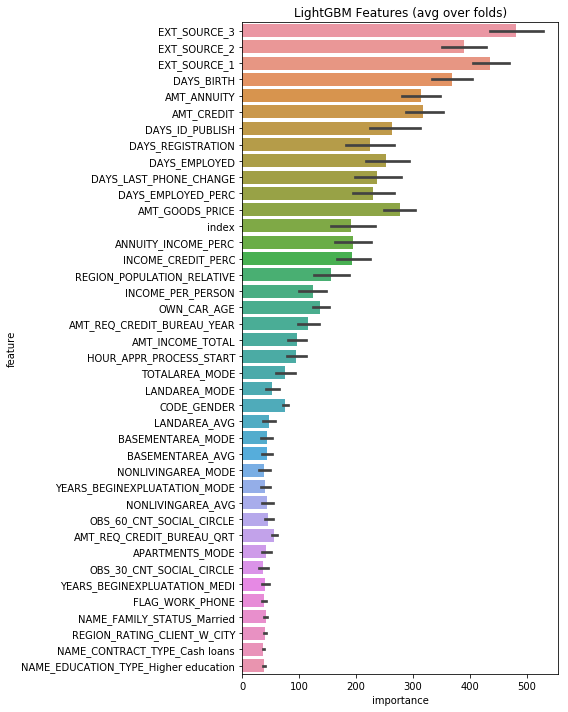

In [24]:
kfold_lightgbm(df, 20, stratified = False)

In [22]:
display_importances(feature_importance_df_)

NameError: name 'feature_importance_df_' is not defined

In [21]:
feature_importance_df_

NameError: name 'feature_importance_df_' is not defined

In [80]:
path = "C://Users//95811//Desktop//kagggle"

In [81]:
data=pd.read_csv("C://Users//95811//Desktop//kagggle//application_train.csv")

In [82]:
data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.000,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.000,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.000,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.000,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
data.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [84]:
dataclean=data.dropna(axis=0)

In [145]:
df=dataclean
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,is_train
71,100083,0,Cash loans,M,Y,Y,0,103500.0,573628.5,24435.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,True
124,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,True
152,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,0,0,0,0.0,0.0,0.0,1.0,0.0,4.0,True
161,100190,0,Cash loans,M,Y,N,0,162000.0,263686.5,24781.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,True
255,100295,1,Cash loans,M,Y,N,1,225000.0,1019205.0,31032.0,...,0,0,0,0.0,0.0,0.0,6.0,0.0,1.0,True
296,100341,0,Cash loans,M,Y,Y,0,76500.0,545040.0,20677.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,True
298,100343,0,Cash loans,M,Y,Y,0,315000.0,90000.0,4504.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,True
316,100363,0,Cash loans,F,Y,Y,1,360000.0,493497.0,48942.0,...,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,True
323,100371,0,Cash loans,F,Y,Y,1,450000.0,808650.0,31464.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,True
328,100376,0,Cash loans,M,Y,Y,0,360000.0,254700.0,20250.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,True


In [147]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .80
df

C:\Users\95811\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,is_train
71,100083,0,Cash loans,M,Y,Y,0,103500.0,573628.5,24435.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,True
124,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,True
152,100179,0,Cash loans,F,Y,N,0,202500.0,675000.0,53329.5,...,0,0,0,0.0,0.0,0.0,1.0,0.0,4.0,True
161,100190,0,Cash loans,M,Y,N,0,162000.0,263686.5,24781.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,True
255,100295,1,Cash loans,M,Y,N,1,225000.0,1019205.0,31032.0,...,0,0,0,0.0,0.0,0.0,6.0,0.0,1.0,True
296,100341,0,Cash loans,M,Y,Y,0,76500.0,545040.0,20677.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,True
298,100343,0,Cash loans,M,Y,Y,0,315000.0,90000.0,4504.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
316,100363,0,Cash loans,F,Y,Y,1,360000.0,493497.0,48942.0,...,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,True
323,100371,0,Cash loans,F,Y,Y,1,450000.0,808650.0,31464.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
328,100376,0,Cash loans,M,Y,Y,0,360000.0,254700.0,20250.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,True


In [144]:
train, test = df[df['is_train']==True], df[df['is_train']==False]
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 6896
Number of observations in the test data: 1706


In [119]:
'OWN_CAR_AGE','FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL'


('OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL')

In [120]:
#features = df.columns[:121]
features = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','CNT_CHILDREN','AMT_REQ_CREDIT_BUREAU_HOUR',
'AMT_REQ_CREDIT_BUREAU_DAY',
'AMT_REQ_CREDIT_BUREAU_WEEK',
'AMT_REQ_CREDIT_BUREAU_MON',
'AMT_REQ_CREDIT_BUREAU_QRT',
'REGION_POPULATION_RELATIVE',
'DAYS_BIRTH',
            'DAYS_EMPLOYED',
            'DAYS_REGISTRATION','DAYS_ID_PUBLISH',
           'OWN_CAR_AGE','FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']

In [155]:
y = pd.factorize(train['TARGET'])[0]
y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [156]:
clf = RandomForestClassifier(n_jobs=3, random_state=0)
clf.fit(train[features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=3,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [157]:
clf.predict(test[features])

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [124]:
clf.predict(test[features])

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [158]:
clf.predict_proba(test[features])
preds = clf.predict(test[features])
metrics=pd.crosstab(test['TARGET'], preds, rownames=['Actual TARGET'], colnames=['Predicted TARGET'])
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [159]:
metrics

Predicted TARGET,0
Actual TARGET,
0,1604
1,102


In [137]:
list(zip(train[features], clf.feature_importances_))

[('AMT_INCOME_TOTAL', 0.07789736699592417),
 ('AMT_CREDIT', 0.10285813855138326),
 ('AMT_ANNUITY', 0.11465692457587526),
 ('CNT_CHILDREN', 0.02066646166111092),
 ('AMT_REQ_CREDIT_BUREAU_HOUR', 0.002346946019414704),
 ('AMT_REQ_CREDIT_BUREAU_DAY', 0.002088069568904026),
 ('AMT_REQ_CREDIT_BUREAU_WEEK', 0.006569626407264474),
 ('AMT_REQ_CREDIT_BUREAU_MON', 0.021667277626884758),
 ('AMT_REQ_CREDIT_BUREAU_QRT', 0.024809317995395718),
 ('REGION_POPULATION_RELATIVE', 0.08277545905897736),
 ('DAYS_BIRTH', 0.10873420014892951),
 ('DAYS_EMPLOYED', 0.10574845346845803),
 ('DAYS_REGISTRATION', 0.11550695796383233),
 ('DAYS_ID_PUBLISH', 0.10155707664131561),
 ('OWN_CAR_AGE', 0.07289929066801315),
 ('FLAG_MOBIL', 0.0),
 ('FLAG_EMP_PHONE', 0.0),
 ('FLAG_WORK_PHONE', 0.012750413122586807),
 ('FLAG_CONT_MOBILE', 0.000810675175221068),
 ('FLAG_PHONE', 0.014029547783276777),
 ('FLAG_EMAIL', 0.01162779656723206)]

In [138]:
a=np.array(test['TARGET'])

In [139]:
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [140]:
#roc_auc_score(a, preds)

In [141]:
b=pd.DataFrame(a-preds)
b.columns=['error']
b

,error
0,0
1,1
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [142]:
b['error'].value_counts()/len(b['error'])

0    0.934833
1    0.065167
Name: error, dtype: float64

In [76]:
data['OCCUPATION_TYPE'].value_counts()/307511

Laborers                 0.179460
Sales staff              0.104393
Core staff               0.089655
Managers                 0.069497
Drivers                  0.060495
High skill tech staff    0.037007
Accountants              0.031911
Medicine staff           0.027762
Security staff           0.021856
Cooking staff            0.019336
Cleaning staff           0.015131
Private service staff    0.008624
Low-skill Laborers       0.006806
Waiters/barmen staff     0.004384
Secretaries              0.004244
Realty agents            0.002442
HR staff                 0.001831
IT staff                 0.001711
Name: OCCUPATION_TYPE, dtype: float64

In [1]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns